# C1 - Introduction to Human and Computer Vision
## Week 2 - Draft Notebook

In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import os
import re
import matplotlib.pyplot as plt

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week2')
os.chdir(BASE_PATH)
BASE_PATH

'/home/alex/Documents/MCV/C1/Team5/week2'

### Load datasets

In [68]:
from src.image_dataset import ImageDataset, ColorSpace
from src.consts import DescriptorType

DATA_DIRECTORY = '../data'

params = {
    'colorspace': ColorSpace.CieLab,
    'intervals': [7, 7, 7],
    'rows': 12,
    'columns': 12,
    'channels': [[0], [1], [2]]
}

BDDataset = ImageDataset(f'{DATA_DIRECTORY}/BBDD', DescriptorType.Block, params)
QueryDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd1_w1', DescriptorType.Block, params)

### Task 1 - Block and hierarchical histograms

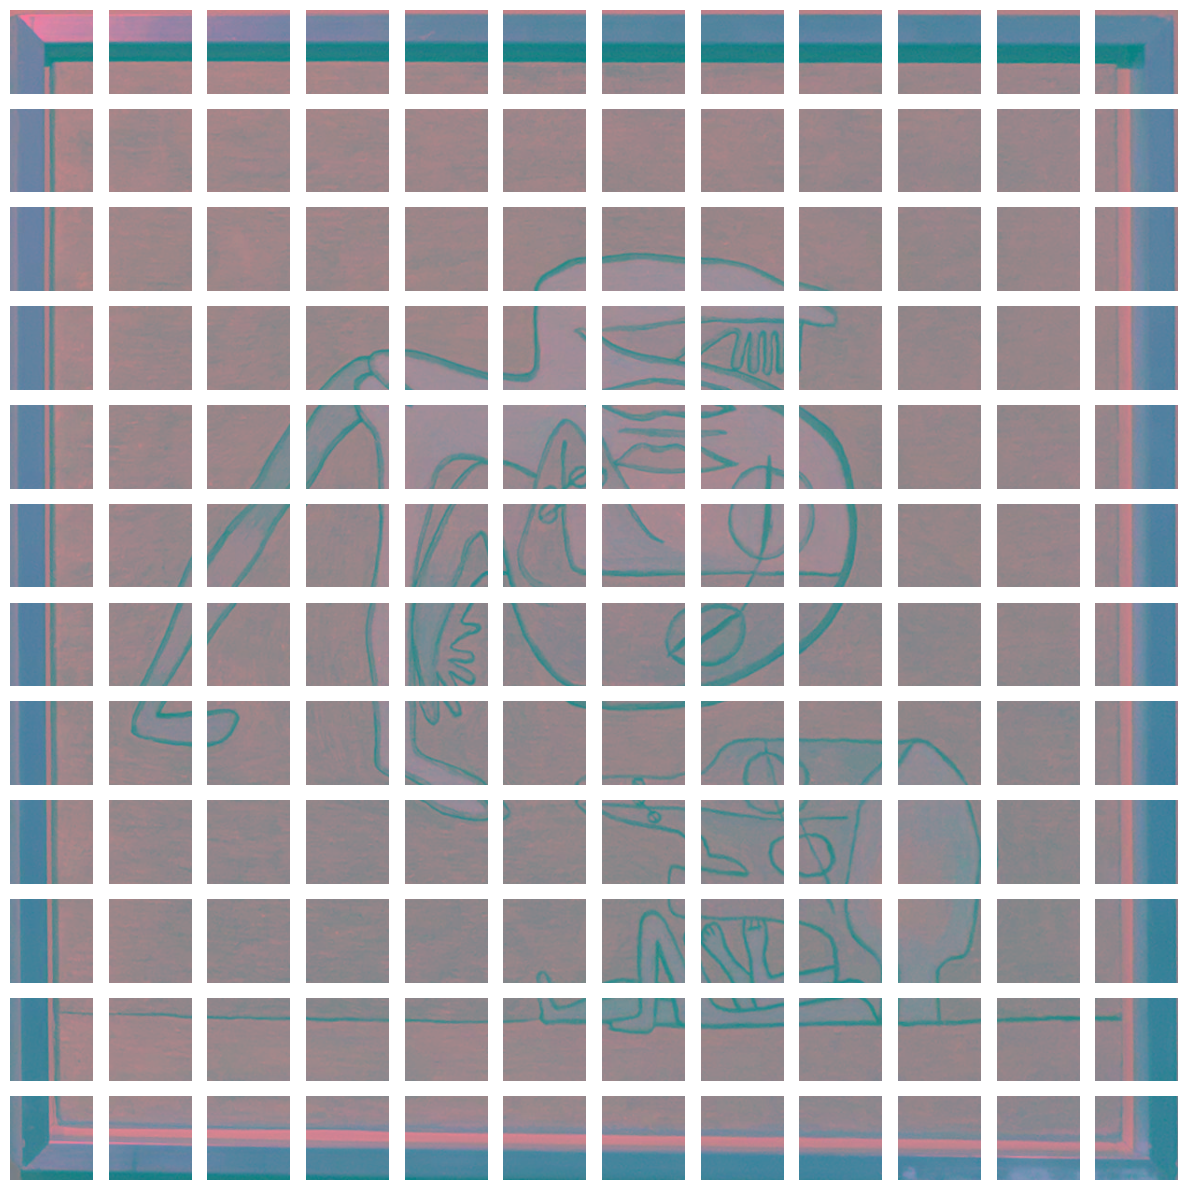

In [69]:

image = QueryDataset[0]

# ----- Plot the Image Blocks -----
fig, axes = plt.subplots(params['rows'], params['columns'], figsize=(params['columns'], params['rows']))
    
for i in range(params['rows']):
    for j in range(params['columns']):
        axes[i, j].imshow(image.descriptors.blocks[i][j])
        axes[i, j].axis('off') 

plt.tight_layout()
plt.show()

In [72]:
len(image.descriptors), len(image.descriptors[0]), image.descriptors[0][0].shape

(12, 12, (108,))

Notice how:

255 // 10 intervals = 25 bins and

36 bins*3 image channels = 108 concatenated color channels for each block

#### Spatial Pyramid Representation

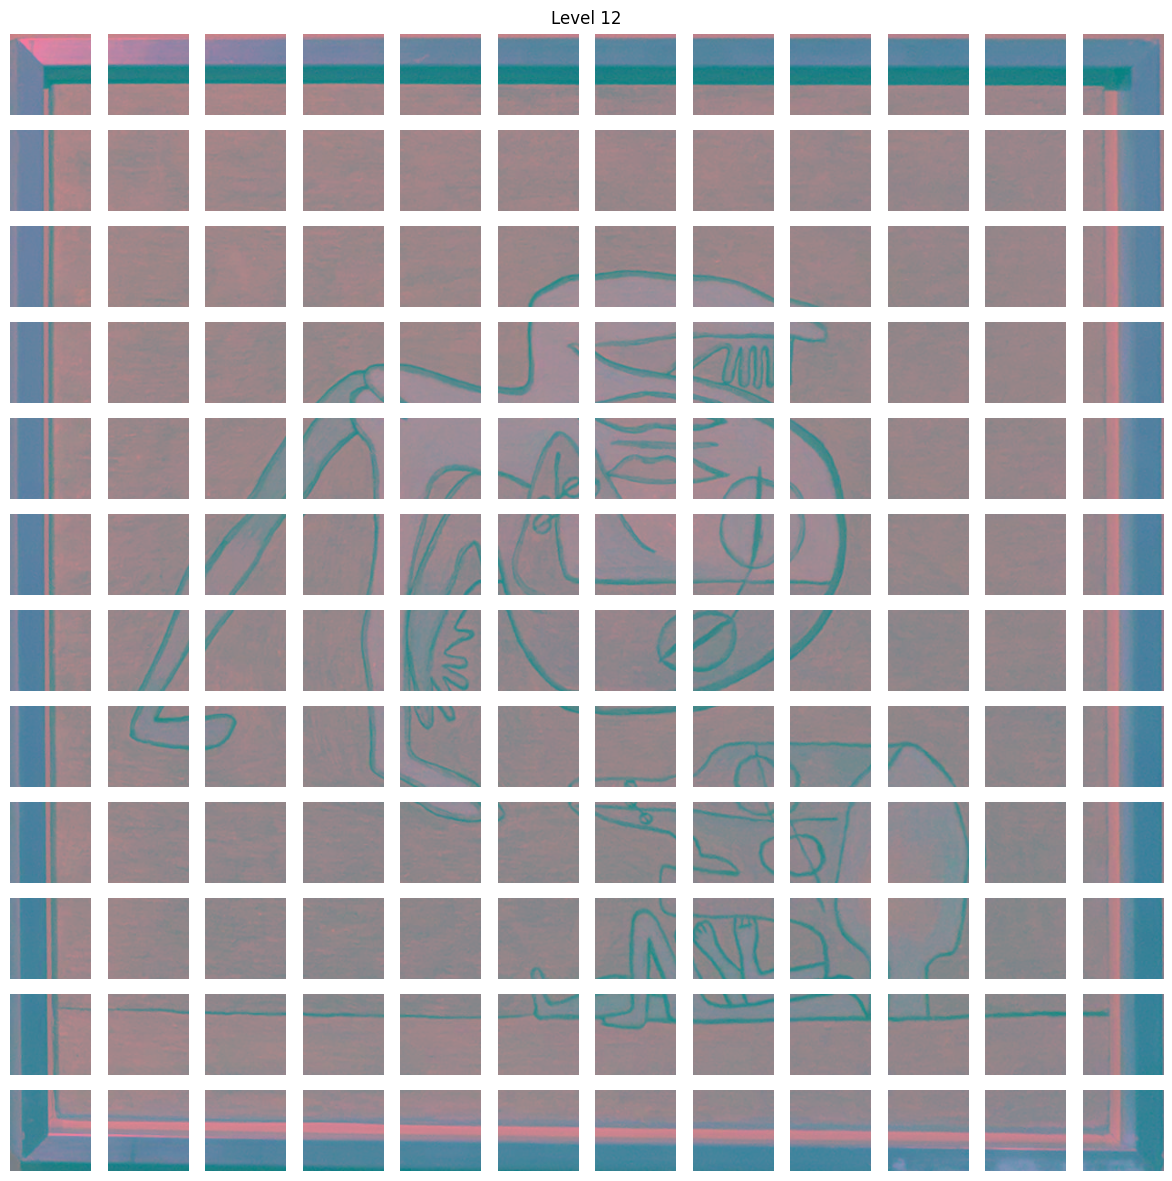

In [73]:
# Let's start by square grids

# The level indicates the size of the grid used to divide the image by block. For example, level 4 indicates we divide the image with a grid of 4x4 blocks
levels = [12]

for level in levels:
    ROWS = level
    COLUMNS = level

    # Update histogram_descriptor
    image.descriptors.compute_image_histogram_descriptor(intervals=params['intervals'], rows=ROWS, columns=COLUMNS)

    # ----- Plot the Image Blocks -----
    fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(COLUMNS, ROWS))
        
    for i in range(ROWS):
        for j in range(COLUMNS):
            axes[i, j].imshow(image.descriptors.blocks[i][j])
            axes[i, j].axis('off') 

    plt.suptitle(f'Level {level}')
    plt.tight_layout(w_pad=0.1)
    plt.show()



### Task 2 - Evaluate retrieval results

#### Block-based Histograms

In [74]:
import pickle

# Get ground truth
with open(f'{DATA_DIRECTORY}/qsd1_w1/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

In [75]:
from src.evaluation import compute_results_by_similarity, compute_results_by_distance
from src.metrics import SimilarityType, DistanceType
import numpy as np

metric = DistanceType.l1

res = compute_results_by_distance(
    BDDataset, QueryDataset, ground_truth, metric,
)

result = {}
result[metric.__name__] = {
    'mapk1': np.mean(res['apk1']),
    'mapk5': np.mean(res['apk5'])
}

print(result)

{'l1_distance': {'mapk1': np.float64(0.9), 'mapk5': np.float64(0.9166666666666666)}}


#### Spatial Pyramid Representation

In [9]:
import importlib
from src.metrics import DistanceType
from src.evaluation import compute_result_list_similarity, compute_result_list_distance

levels = [7]

res = {}

metric = DistanceType.l1

for level in levels:    
    for image in BDDataset.images:
        image.descriptors.compute_image_histogram_descriptor(params['intervals'], level, level)
    
    for image in QueryDataset.images:
        image.descriptors.compute_image_histogram_descriptor(params['intervals'], level, level)
    
    res_i = compute_result_list_distance(
        BDDataset, QueryDataset, metric,
    )

    res[level] = res_i

In [10]:
final_result = []
for i in range(len(QueryDataset)):
    prediction_levels = [res[level][i] for level in levels]
    final_result.append([(tup[0][0], min(tup[i][1] for i in range(len(tup)))) for tup in zip(*prediction_levels)])

In [11]:
if metric == DistanceType.l1:
    sorting_key = lambda x: x[1]
else:
    sorting_key = lambda x: -x[1]

for i in range(len(final_result)):
    final_result[i] = sorted(final_result[i], key=sorting_key)

top10s = [[x[i][0] for i in range(10)] for x in final_result]

In [12]:
from src.metrics import mapk

print('APK1: ', mapk(ground_truth, top10s, k=1))
print('APK5: ', mapk(ground_truth, top10s, k=5))

APK1:  0.8666666666666667
APK5:  0.9


### Task 3 - Background removal

In [47]:
BGDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd2_w2', DescriptorType.Block, params)

#### Plot Original / Groundtruth / Obtained Mask

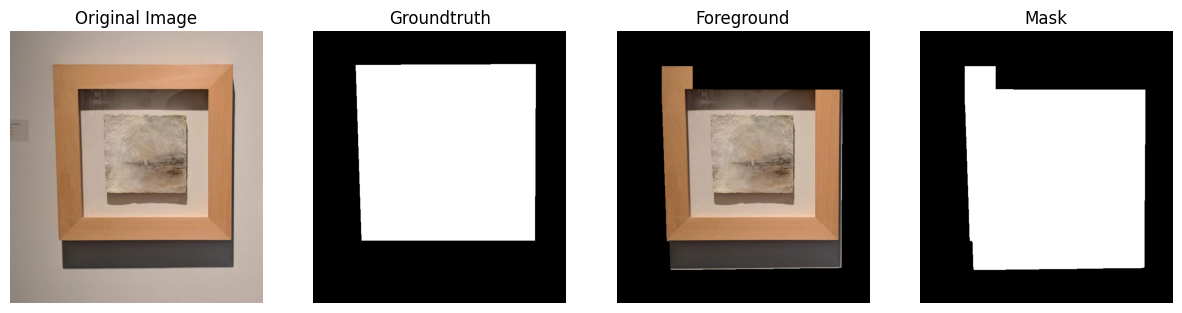

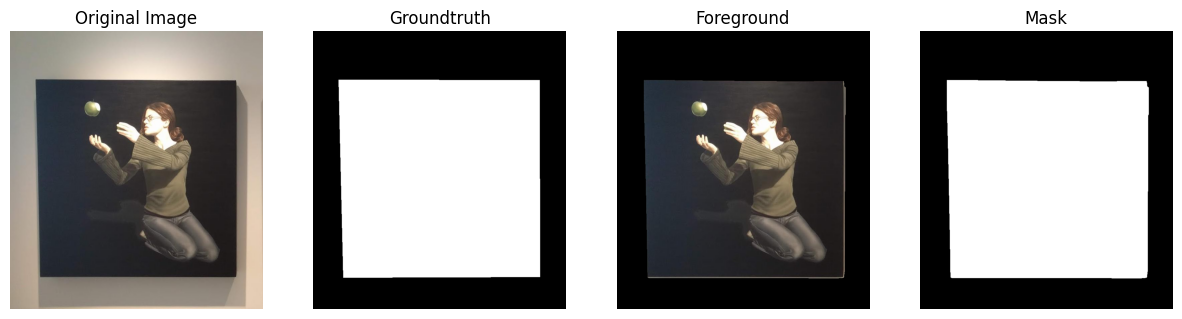

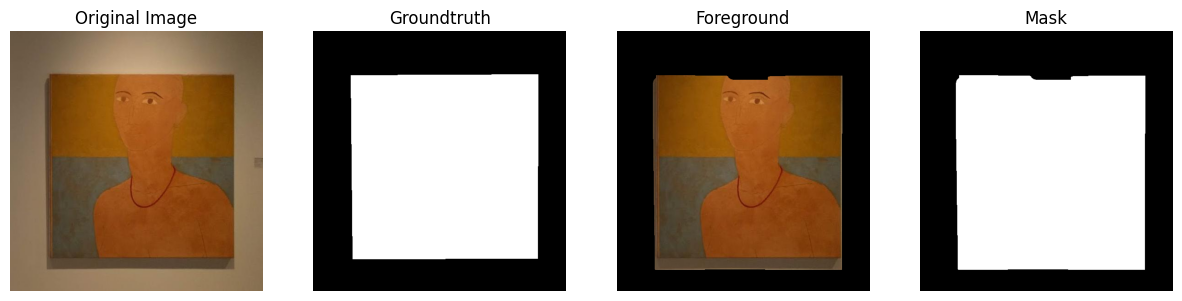

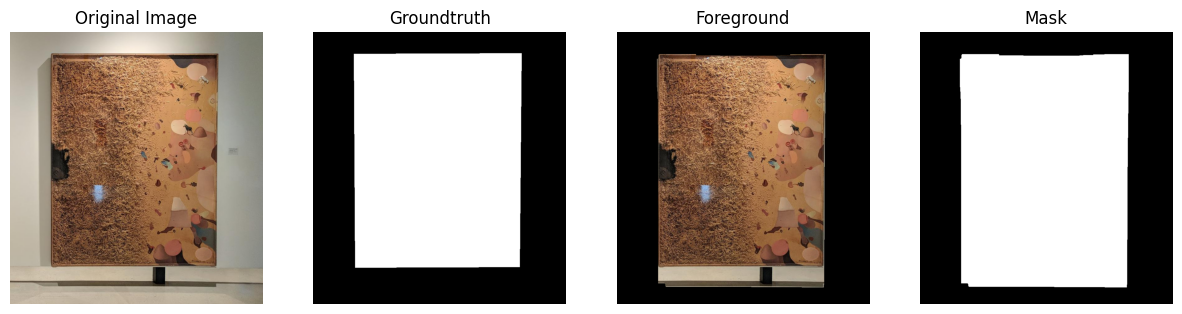

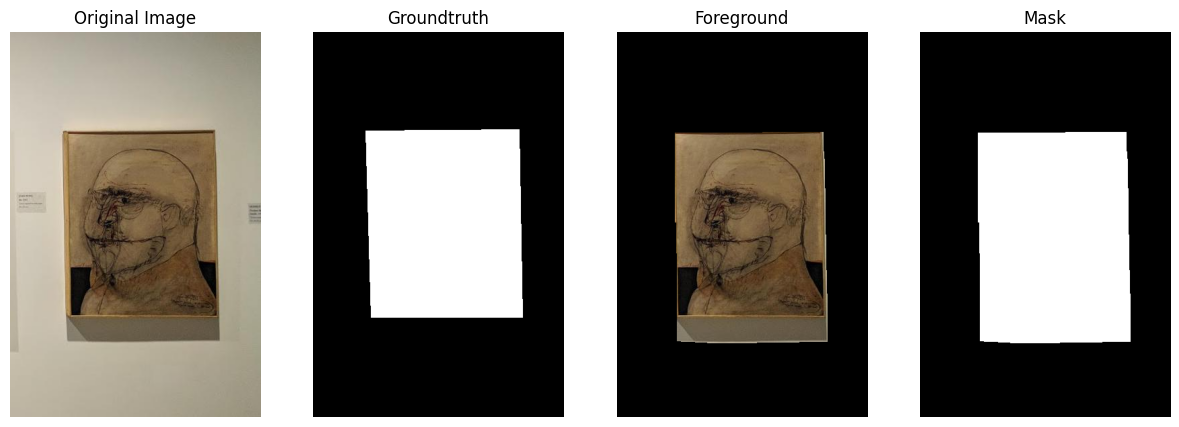

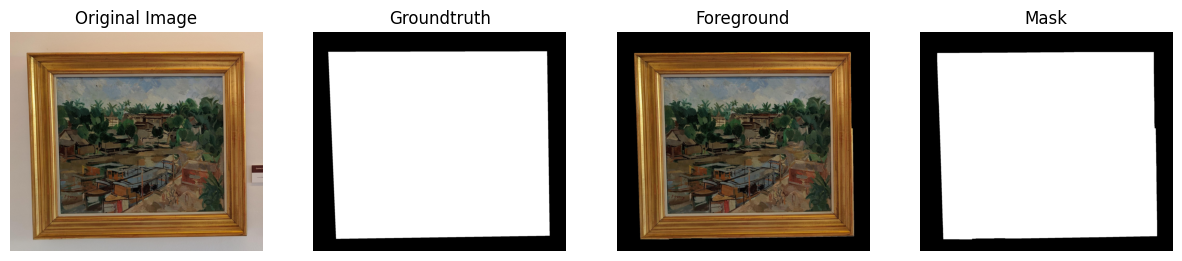

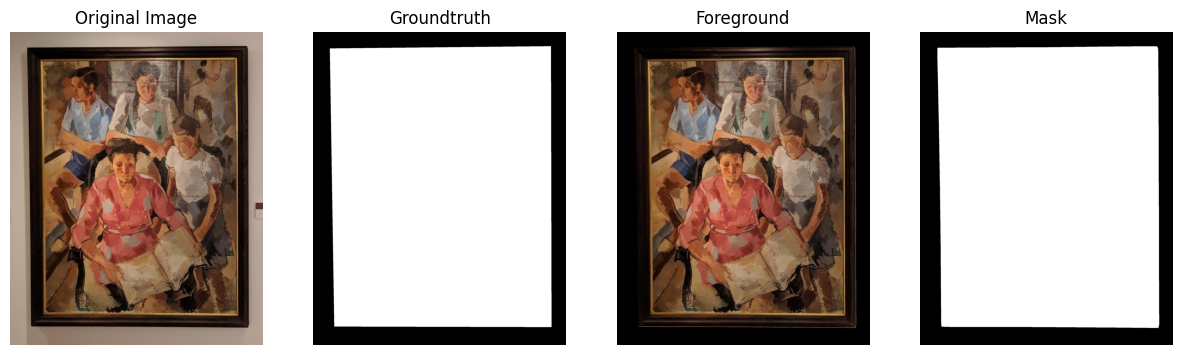

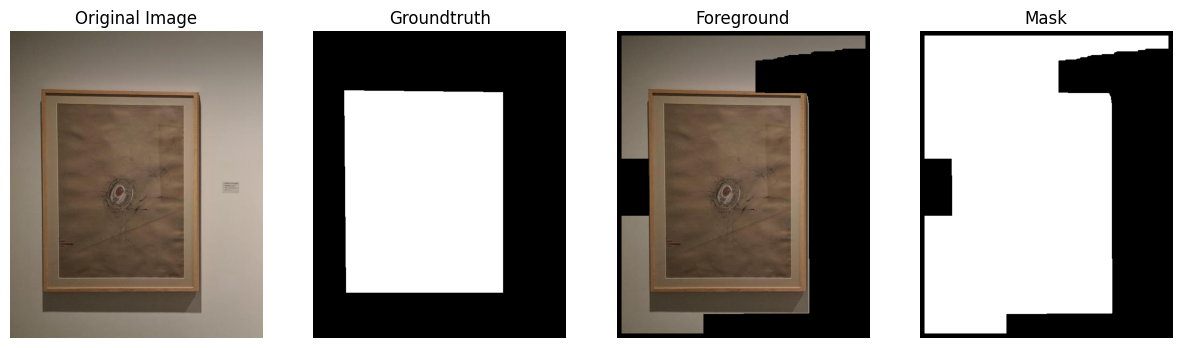

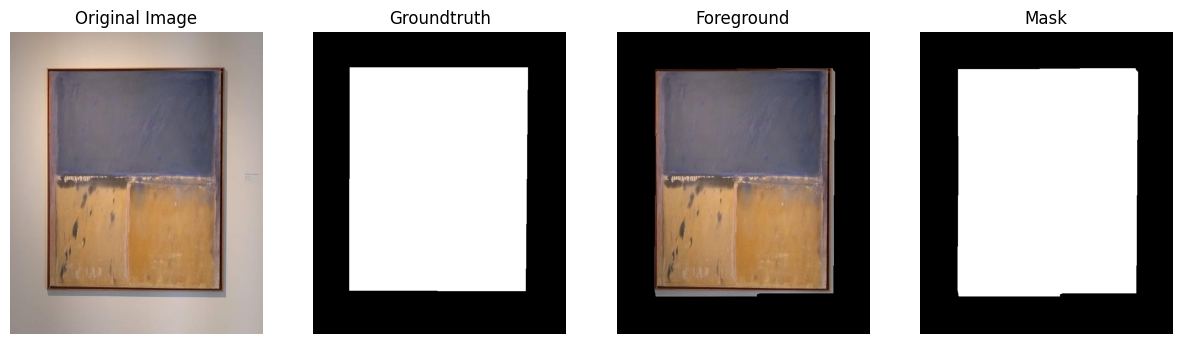

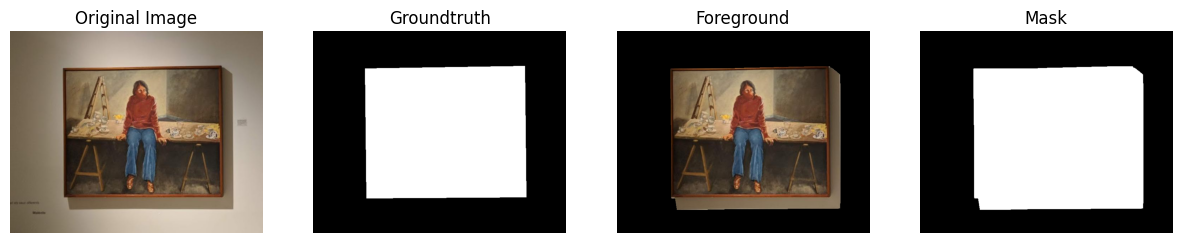

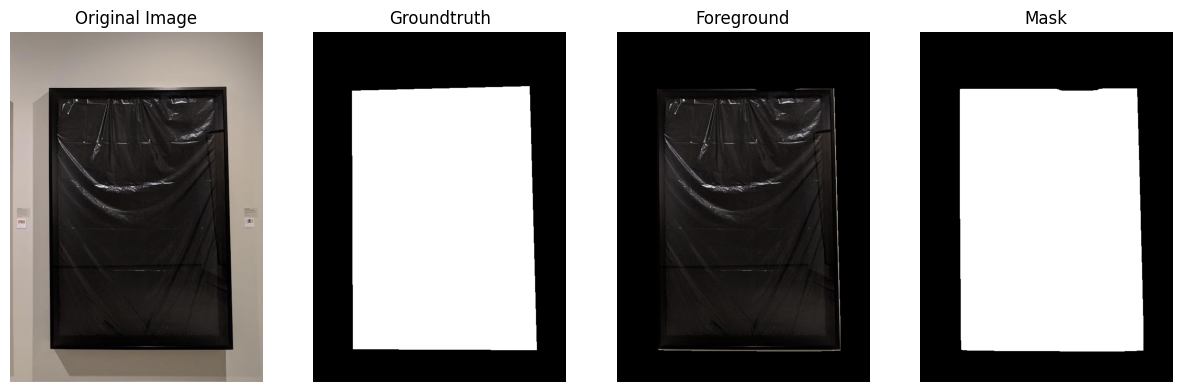

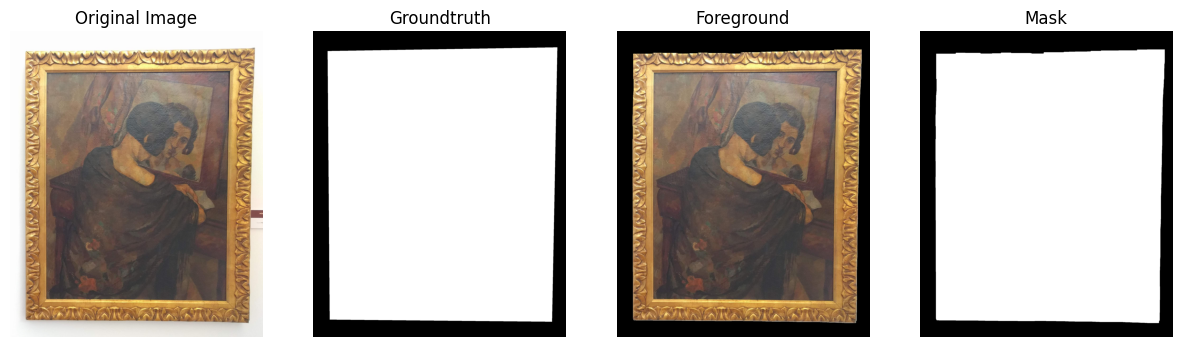

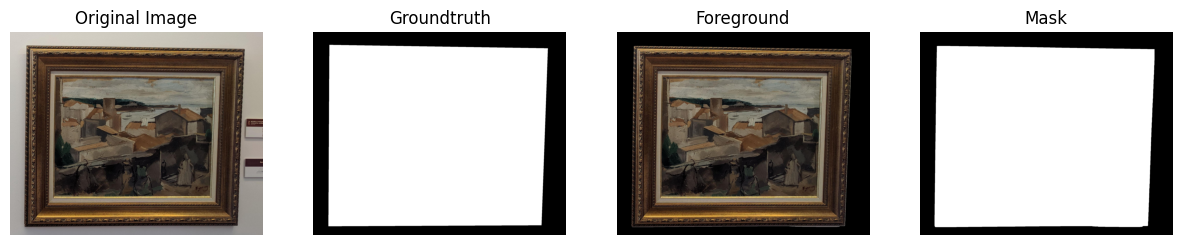

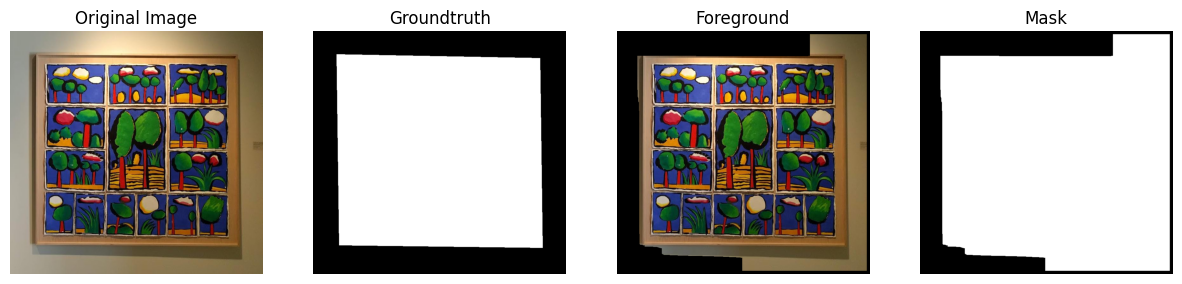

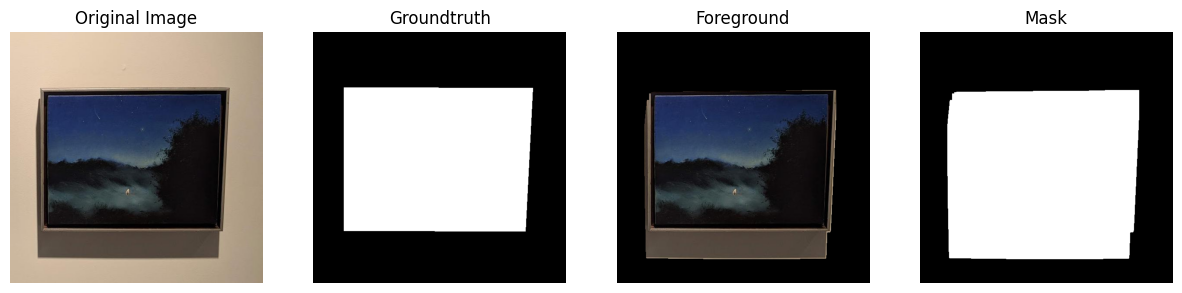

In [35]:
import importlib
import cv2
import src.background_removal


from src.background_removal import get_mask_and_foreground

background_files = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd2_w2') if f.endswith('.png')]
background_files = sorted(background_files, key=lambda x: int(re.findall(r'\d+', x)[0]))

# Loop will need to be changed to len(background_files) --> for i in range(0, len(background_files))
for i in range(0, 15):
    image = cv2.cvtColor(BGDataset.images[i].original_image, cv2.COLOR_BGR2RGB)

    # Original Image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Groundtruth
    ground_truth = os.path.join(f'{DATA_DIRECTORY}/qsd2_w2', background_files[i])
    ground_truth = cv2.imread(ground_truth)
    plt.subplot(1, 4, 2)
    plt.imshow(ground_truth)
    plt.title('Groundtruth')
    plt.axis('off')

    # Get foreground and mask
    foreground, mask = get_mask_and_foreground(image)
    plt.subplot(1, 4, 3)
    plt.imshow(foreground)
    plt.title('Foreground')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

In [16]:
mask, foreground = get_mask_and_foreground(image)

#### Save masks

In [17]:
FOREGROUND_DIR = "data_results/foregrounds"
MASK_DIR = "data_results/masks"

In [18]:
for path in [FOREGROUND_DIR, MASK_DIR]:
    if not os.path.exists(path):
        os.makedirs(path)

def get_image_filename(path):
    """
    Returns image filename (e.g. 00000, 00001, ...)
    """
    base_name = os.path.basename(path)
    file_name = os.path.splitext(base_name)[0]
    return file_name

# Save Foreground and Masks results
for i in range(0, len(background_files)):
    image = cv2.cvtColor(BGDataset.images[i].original_image, cv2.COLOR_BGR2RGB)
    filename = get_image_filename(BGDataset.images[i].path)

    # Get the foreground and mask
    foreground, mask = get_mask_and_foreground(image)

    # Define paths for saving
    foreground_path = os.path.join(FOREGROUND_DIR, f"{filename}.png")
    mask_path = os.path.join(MASK_DIR, f"{filename}.png")

    # Save the foreground and mask
    cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, mask)

### Task 4 - Masks evaluation

In [19]:
import pandas as pd
import src.background_removal

# Reload after making changes
importlib.reload(src.background_removal)
from src.background_removal import evaluate_masks

# First directory needs to be updated!
precision, recall, f1_score = evaluate_masks(f'{MASK_DIR}', f'{DATA_DIRECTORY}/qsd2_w2')

results = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [precision, recall, f1_score]
})
print(results)

      Metric     Value
0  Precision  0.911154
1     Recall  0.936273
2   F1 Score  0.914322


### Task 5 - Retrieval

In [37]:
from src.background_removal import get_mask_and_foreground
image = BGDataset[0]
_, mask = get_mask_and_foreground(image.descriptors.original_image)
mask.shape

(650, 605)

In [48]:

for image in BGDataset:
    _, mask = get_mask_and_foreground(image.descriptors.original_image)
    image.descriptors.compute_image_histogram_descriptor(
        params['intervals'],
        params['rows'],
        params['columns'],
        params['channels'],
        mask=mask)

In [49]:
from src.evaluation import DistanceType, compute_results_by_distance
import pickle
import numpy as np

metric = DistanceType.l1

with open(f'{DATA_DIRECTORY}/qsd2_w2/gt_corresps.pkl', 'rb') as f:
    ground_truth_qsd2_w2 = pickle.load(f)

res = compute_results_by_distance(
    BDDataset, BGDataset, ground_truth_qsd2_w2, metric,
)

result = {}
result[metric.__name__] = {
    'mapk1': np.mean(res['apk1']),
    'mapk5': np.mean(res['apk5'])
}

print(result)

{'l1_distance': {'mapk1': np.float64(0.5666666666666667), 'mapk5': np.float64(0.6327777777777778)}}


### Task 6 - .pkl results generation

In [76]:
TestDataset = ImageDataset(f'{DATA_DIRECTORY}/qst_w2/w2/qst1_w2/', DescriptorType.Block, params)

In [78]:
result = []
for image in TestDataset:
    distnaces_list = []
    for image2 in BDDataset:
        distnaces = image.compute_distance(image2, type=DistanceType.l1)
        distance = np.mean(distnaces)
        distnaces_list.append(distance)
    top_k = np.argsort(distnaces_list)[:10]

    result.append([BDDataset[i].index for i in top_k])

In [79]:
result

[[35, 194, 212, 205, 252, 40, 270, 226, 97, 16],
 [131, 110, 121, 240, 128, 173, 213, 231, 46, 180],
 [91, 51, 225, 117, 187, 58, 146, 215, 184, 85],
 [182, 85, 97, 184, 226, 212, 165, 35, 224, 187],
 [222, 194, 120, 205, 35, 252, 187, 40, 226, 211],
 [260, 286, 248, 21, 26, 279, 84, 123, 133, 57],
 [117, 217, 5, 73, 146, 106, 21, 68, 213, 162],
 [78, 147, 248, 227, 155, 84, 99, 140, 65, 253],
 [257, 21, 138, 57, 197, 106, 258, 46, 279, 217],
 [218, 110, 240, 231, 216, 173, 128, 157, 133, 180],
 [67, 182, 184, 85, 97, 38, 114, 224, 35, 165],
 [132, 130, 192, 225, 88, 103, 113, 58, 215, 51],
 [25, 104, 200, 29, 145, 154, 163, 42, 143, 105],
 [212, 270, 85, 194, 97, 148, 165, 5, 187, 1],
 [34, 173, 216, 197, 162, 240, 238, 128, 254, 21],
 [176, 29, 200, 12, 105, 16, 60, 24, 95, 205],
 [150, 95, 93, 176, 16, 205, 12, 200, 271, 187],
 [85, 254, 187, 92, 226, 79, 224, 165, 110, 157],
 [22, 205, 16, 12, 93, 211, 14, 1, 194, 252],
 [36, 106, 258, 49, 217, 162, 18, 5, 35, 209],
 [248, 205, 244

In [80]:
with open(f'./data_results/result.pkl', 'wb') as file:
    # Use pickle.dump to write the list to the file
    pickle.dump(result, file)

In [81]:
TestDataset = ImageDataset(f'{DATA_DIRECTORY}/qst_w2/w2/qst2_w2/qst2_w1', DescriptorType.Block, params)

In [82]:
for image in TestDataset:
    _, mask = get_mask_and_foreground(image.descriptors.original_image)
    image.descriptors.compute_image_histogram_descriptor(
        params['intervals'],
        params['rows'],
        params['columns'],
        params['channels'],
        mask=mask)

In [85]:
result = []
for image in TestDataset:
    distnaces_list = []
    for image2 in BDDataset:
        distnaces = image.compute_distance(image2, type=DistanceType.l1)
        distance = np.mean(distnaces)
        distnaces_list.append(distance)
    top_k = np.argsort(distnaces_list)[:10]

    result.append([BDDataset[i].index for i in top_k])

In [86]:
result

[[35, 197, 217, 146, 208, 21, 68, 106, 258, 11],
 [276, 176, 22, 281, 12, 261, 74, 152, 92, 95],
 [85, 224, 187, 97, 165, 146, 184, 182, 226, 79],
 [35, 68, 197, 226, 217, 5, 21, 79, 41, 273],
 [212, 35, 187, 226, 40, 68, 18, 41, 165, 217],
 [286, 57, 271, 21, 116, 72, 225, 241, 126, 103],
 [85, 187, 79, 224, 184, 226, 41, 146, 217, 165],
 [217, 173, 106, 127, 240, 216, 21, 190, 73, 46],
 [176, 105, 29, 200, 95, 12, 150, 93, 60, 205],
 [110, 57, 225, 271, 218, 187, 146, 46, 241, 259],
 [179, 219, 240, 254, 127, 173, 216, 128, 238, 231],
 [225, 130, 31, 160, 72, 110, 163, 215, 113, 127],
 [93, 187, 95, 12, 191, 137, 195, 149, 150, 42],
 [231, 110, 240, 216, 123, 21, 121, 57, 46, 128],
 [183, 15, 118, 133, 46, 21, 139, 138, 174, 221],
 [81, 244, 218, 82, 110, 37, 150, 105, 271, 281],
 [286, 225, 170, 57, 146, 130, 187, 46, 21, 271],
 [130, 58, 225, 215, 192, 132, 160, 51, 161, 239],
 [187, 205, 203, 93, 150, 16, 46, 271, 146, 110],
 [227, 57, 133, 121, 157, 110, 218, 26, 244, 84],
 [257,

In [87]:
with open(f'./data_results/result.pkl', 'wb') as file:
    # Use pickle.dump to write the list to the file
    pickle.dump(result, file)